In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def density_of_states_behte_non_int (omega, D):
    '''
    density of states of a Bethe lattice with infinite connectivity 
    (from the analytical expression of the non interacting GF)

    input:      omega       real frequency/energy 
                D           bandwidth, the density of states is non zero for |omega|<D

    output:     rho(omega)  densiy of states, rho(w)=2*sqrt(D^2-w^2)/pi*D^2
    '''

    return 2*np.sqrt(D**2-omega**2)/np.pi*D**2



/var/folders/p9/vmfpstws7vd67rl49m49vhxr0000gq/T/ipykernel_16290/3915838211.py:12: RuntimeWarning: invalid value encountered in sqrt
  return 2*np.sqrt(D**2-omega**2)/np.pi*D**2


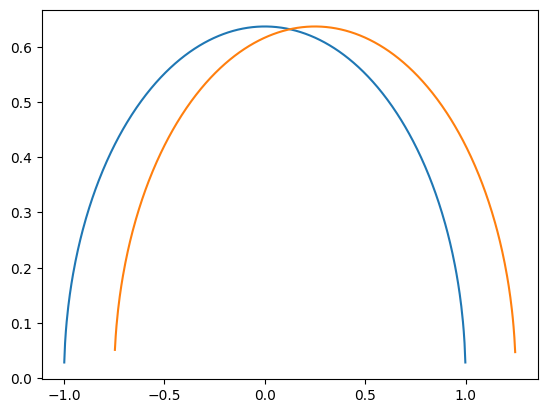

In [7]:
ww = np.linspace(-2.,2.,1000)
rho_bethe = density_of_states_behte_non_int(omega=ww, D=1.)
plt.plot(ww, rho_bethe)


# I introduce a chemical potential: rho(e)->rho(e-mu)
mu = 0.25
rho_bethe_mu= density_of_states_behte_non_int(omega=ww-mu, D=1.)
plt.plot(ww, rho_bethe_mu)

In [5]:
def impurity_non_int_greens_func(iomega, local_greens_func, local_self_energy):
    '''
    non interacting Green's function of the auxiliary system
    (step (3): find G_0 coursive)

    input:      iomega                      matzubara frequency 
                local_greens_func(iomega)    function of omega: local interacting Green's function (of the reference embedded site) as encoded in step (2)
                local_self_energy(iomega)    function of omega: local self energy (of the reference embedded site) as encoded in step (1)

    output:     G_0 coursive(iomega)         non interacting GF of the auxiliary system, G_0 coursive(w)=(G_loc^-1+Sigma_loc)^-1
    '''

    G_loc = local_greens_func(iomega)
    Sigma_loc = local_self_energy(iomega)

    return 1/( (1/G_loc) + Sigma_loc )

In [6]:
N_cutoff = 1000
##### TODO:  CHECK THE CUTOFF FOR EVALUATING THE SUM IN THE FOURIER TRANSFORM  ############


def fourier_trans_to_imag_time(func, beta, tau):
    '''
    Fourier transform of a function G(i*omega_n) where i*omega_n are Matzubara frequencies
    (needed to perform the Iterative Perturbation Theory Step)
    
    input:      func        G(i*omega_n): function of i*omega (Matzubara frequencies)
                beta        inverse temperature
                tau         imaginary time        

    output:     G(tau)      function of the imaginary time (tau), G(tau)=(1/beta)* sum_(w_n)  (e^i*w_n*tau)*G(i*omega_n)
    '''

    nn = range(start=-N_cutoff, stop=N_cutoff)
    matz_frequencies = np.pi*(1/beta) * (2*nn + 1)
    
    G_iw = func(matz_frequencies)
    exponential_iw = np.exp(-1j * matz_frequencies*tau)

    return  np.sum(exponential_iw*G_iw) / beta


In [ ]:
########### TODO: I believe U needs to be updated at every cycle as we need to solve the problem of the auxiliary system with some sort of effective interaction
#### do we need to use the hybridization function????

########### TODO: find limits of integration for the integral in time!!!  time_integral_steps=1000

def iterative_perturbation_theory_impurity_solver(impurity_non_int_greens_func, iomega, U, beta):
    '''
    finds the self energy of the auxiliary Anderson impurtity model Sigma_imp
    from this it evaluates also the interacting Green's function of the auxiliary system (G coursive)

    input:      impurity_non_int_greens_func        G_0 (iomega) coursive: non interacting Green's function of the auxiliary system
                                                                           encoded in step (3) and evaluated on Matzubara frequency
                iomega                              Matzubara frequency i*omega_n
                U                                   impurity interaction
                beta                                inverse temperature  

    output:     impurity_self_energy(iomega)        self energy of the auxiliary system    Sigma_imp(iw)=U/2 + U^2 * int_0^beta d(tau) (e^i*w_n*tau) * G_0^shifted(tau)^3
                                                                                           knowing G_0^shifted(iw)= (G_0(iw)^-1  - U/2)^-1     where all the G are coursive
                impurity_int_greens_func(iomega)    interacting GF of the auxiliary system   G(iw) = (  G_0(iw)^-1 - Sigma_imp(iw)  )^-1          where all the G are coursive

    note: this fucntion uses the function fourier_trans_to_imag_time() to convert G_0^shifted(iw) coursive in imaginary time
    '''

    # I calculate G_0_shifted(iw) as a function of iomega
    shifted_impurity_non_int_greens_func = lambda iw : 1 / ( (1/impurity_non_int_greens_func(iw)) - U*0.5 )

    # I calculate the fourier transform G_0_shifted(tau)
    time_integral_steps=1000
    tau = np.linspace(start=0, stop=beta, num=time_integral_steps)
    G_0_shifted_tau = fourier_trans_to_imag_time(shifted_impurity_non_int_greens_func, beta, tau)
    exponential_tau = np.exp(1j * iomega*tau)


    # I calculate the integral
    integral = np.sum(exponential_tau * G_0_shifted_tau**3)

    # I get Sigma_imp and the interacting GF of the impurity
    Sigma_imp = U*0.5 + U**2  * integral

    G_0_iw = impurity_non_int_greens_func(iomega)
    G_imp = 1 / ( 1/G_0_iw - Sigma_imp ) ############ TODO cCHEKKKKKKKKK
    return Sigma_imp, G_imp

